# Ames, Iowa Housing Data - Results Visualization

In this notebook, we visualize and analyze our results to draw our conclusions and recommendations for house purchasing in Ames
- [Results Visualization](#Results-Visualization)
- [Conclusions](#Conclusions)

In [1]:
# Import relevant libraries

import matplotlib.pyplot as plt
import numpy as np
from general_functions import LeeFunctions as lf

In [2]:
%%capture
%store -r model_pass

# Retrieve passed objects from the modeling notebook: data sets, fitted scaler, and fitted linear regression model. 
# If that file has not been run, this executes that code first and then retrieves the information

try:
    model_pass
except:
    %run ./p2_model.ipynb
    %store -r model_pass
    
datasets = model_pass[0]
ss = model_pass[1]
lr = model_pass[2]

## Results Visualization
We assess here which of our variables had the strongest predictive power, as well as calculating how much sale price increases for a unit change in each feature. From this, we can determine which features play the largest role in determining housing prices, which allow us to make more informed decisions on the value of a new house based on its qualities

In [3]:
# Pull coefficients from the fitted model. Condense categorical variables (bldg_type, overall_qual, and neighborhood) to the range of the variable (reference column = 0)
# Create arrays of relative value for overall quality and neighborhood

coef_dict = {np.array(datasets[0].columns)[x]: lr.coef_[x] for x in range(len(lr.coef_))}
qual_coef = [round(np.exp(coef_dict[x])*100,2) for x in coef_dict if 'overall' in x]
qual_coef.insert(0,100)
neighbor_coef = [round(np.exp(coef_dict[x])*100,2) for x in coef_dict if 'neighbor' in x]
neighbor_coef.insert(0,100)
area_coef = [0.071, 0.05, 0.134]

for var in ['bldg','neighbor','overall']:
    coefs = [coef_dict[x] for x in coef_dict if var in x]
    coefs.append(0)
    final = np.max(coefs) - np.min(coefs)
    coef_dict[var] = final
del_keys = []
for var in ['type','hood','qual']:
    for x in coef_dict:
        if var in x:
            del_keys.append(x)
for key in del_keys:
    coef_dict.pop(key)

### Categorical Variable Visualization

In [4]:
%%capture
# Plot the coefficients using a horizontal bar chart
labels = ['Age','Garage Area','Living Area','Basement Area','Building Type','Neighborhood','Overall Quality']
lf.create_bar([round(x,3) for x in list(coef_dict.values())], title='Sale Price Model Coefficients', ticks = labels, ylabel='AU', axis='h')

In [5]:
%%capture
# Plot the relative price increase for overall quality
qual_labels = ['1-2','3-4','5-6','7-8','9-10']
lf.create_bar(qual_coef, title='Quality Sale Price Increase', ticks=qual_labels, ylabel='Percent Price', axis='h', xlabel='Overall Quality Rating')

![](../images/coefficients_bars.png)

Since we applied both scaling and a logarithmic transformation to our target variable, the coefficients by themselves do not provide information that is useful for interpretation. However, it does tell us that for the three categorical variables, building type matters relatively little - the most valuable type of home (single family) is priced only approximately 12.5% higher than the lowest value (duplexes) found by taking the natural exponent(0.118). Overall quality has a much greater impact, with the highest quality homes priced at nearly 2.5 times the value of the lowest quality houses. Each increase in overall quality past the first step represents around a 20% increase in sale price, relative to the reference (1-2 quality homes)

Mean neighborhood percent value relative to reference: 100.33071428571428
Standard deviation: 16.12921216935538
[168.87, 75.29, 81.07, 116.56]


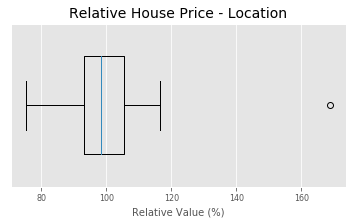

In [6]:
# Determine the mean and standard deviation for the coefficients for the neighborhood dummy features. Create boxplot using neighborhood coefficients (take natural exponent
# and multiply by 100 to get relative percent values)

neighbor_mean = np.mean(neighbor_coef)
neighbor_std = np.std(neighbor_coef)
print(f'Mean neighborhood percent value relative to reference: {neighbor_mean}\nStandard deviation: {neighbor_std}')
print([x for x in neighbor_coef if np.abs(x - neighbor_mean) > neighbor_std])
lf.create_box(neighbor_coef, title = 'Relative House Price - Location', label='Relative Value (%)', size=(6,3))

Most homes in Ames are priced relatively similar to one another based on location, with most neighborhoods falling within one standard deviation (16.13%) of the mean (100.33%) in relation to the reference neighborhood (Bloomington Heights). Four neighborhoods in fall outside of this range. Iowa DOT and Rail Road and Old Town are particularly low value areas at 75.29% and 81.07% relative value, respectively. Stone Brook is positive at 116.56% relative value, while Green Hills is extremely expensive, sitting at a predicted 168.87% relative price, which is likely an outlier in comparison to the rest of the data.

### Numerical Variable Visualization

For comparing the three area features (garage, basement, and ground foor), we un-scale our features, then normalize to a constant measurement (1000 sq. ft.) as opposed to standard deviations, which is different for each feature. Once we have these values, we take the natural exponent to determine the predicted increase in sale price per 1,000 sq. ft. for that feature

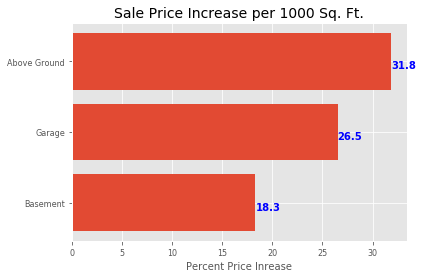

In [7]:
# De-scale and normalize area feature coefficients to determine the percent price increase for every 100 square feet for each feature

area_stdev = (ss.var_[1:4])**0.5
area_val = [round((np.exp(((1000*area_coef[x])/area_stdev[x]))*100)-100,1) for x in range(3)]
area_labels = ['Basement', 'Garage','Above Ground']

lf.create_bar(area_val, title='Sale Price Increase per 1000 Sq. Ft.', ticks=area_labels, ylabel='Percent Price Inrease', axis='h', xlabel='')

In [8]:
# Perform the same de-scaling as above to determine how much age depreciates the value of a home per 10 years
print(f'Percent price decrease per 10 years of age: {round((np.exp(((10*-0.062/(ss.var_[0]**0.5))))*100)-100,1)}')

Percent price decrease per 10 years of age: -2.9


Age does not have a drastic impact on the price of a home. For every 10 years since the house was built (or last remodeled) the price drops by only approximately 3%. Therefore a home 50 years old will see only a relative price decrease of around 15% in comparison to a new home

### Conclusions
Using machine learning, we have fit a multiple linear regression model in order to predict the sale prices of homes in Ames, Iowa. Our model was 90% effective in accounting for the variance exhibited in the data we modeled, and utilized a relatively small number of features in order to create this model. From our results, we determined that several features make a relatively minor impact overall to housing prices. The location of the home, for most neighborhoods, is clustered within a relatively small range, although there are a few exceptions. Of course, there are outside reasons for these price differentials (infrastructure, community and so forth), if those areas are not of interest, then settling in one of the other neighborhoods will not see a drastic change in price, so you can select the neighborhood most to your liking without having to worry about the financial repurcussions. Similarly, age has a relatively small impact on the price; 3% decrease per 10 years. From a value perspective (need for repairs and other maintenance) it is likely more economical to purchase newer houses in general.

The other features had a much greater impact on project sale price. Overall quality of the house, unsurprisingly, plays a big factor in determining how much a home sells for. When evaluating a potential house, it will be important to consider the condition and quality of the house, and whether you are willing to pay a premium for a well maintained home, or if a home lower on the scale will suffice, as this can represent shifts of 20 to 40%. House size, especially the garage and living areas, also represents 20 to 30% differences in price per 1,000 square feet. Again, it is up to your personal preference as to how much the increased space is worth to you.

Ultimately, this model is not designed to select the perfect house for you. What this model provides are benchmarks for you to determine if you are getting a fair deal or not. If you are interested in a 2,000 sq. ft. home for 250,000 USD, but the 1,800 sq. ft. home next door is selling for 220,000, we can help you determine if you are overpaying for the increase in size (disregarding other factors of course). With our model, we can help you make those assessments and evaluate any homes you are interested in order to ensure that you are getting the best home you can for your money